In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

april16_1996 = '1996-04-16T00:00:00.000Z'
april16_1996 = astropy.time.Time(april16_1996).jd
print(april16_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5
2450189.5


In [3]:
dates = []
distances = []
firstOrderFluxes = []
centralOrderFluxes = []

for i in range(1995,2025):
    try:
        datachunk = Table.read("./CELIAS-SEM/{0}_v4.day".format(str(i)[2:4]), format="ascii.no_header", guess=False, fast_reader=False, comment=";", data_start=0)
    except FileNotFoundError:
        continue
    datachunk.rename_column('col1', 'jd') 
    datachunk.rename_column('col13','distance')           # distance from Sun in km
    datachunk.rename_column('col15','firstOrderFlux')     # at distance given in column above. units photons cm^-2 s^-1
    datachunk.rename_column('col16','centralOrderFlux')   # at distance given in column above. units photons cm^-2 s^-1

    dates.extend(datachunk['jd'])
    distances.extend(datachunk['distance'])
    firstOrderFluxes.extend(datachunk['firstOrderFlux'])
    centralOrderFluxes.extend(datachunk['centralOrderFlux'])
    #print(datachunk['jd'][0])
    #print('')
    #print(datachunk['jd'][-1])

dates = np.array(dates)
distances = np.array(distances)
firstOrderFluxes = np.array(firstOrderFluxes)
centralOrderFluxes = np.array(centralOrderFluxes)

#note that these dates start on jan 1, 1995 for some reason--all fluxes are zero till spacecraft starts taking data in december 1995

print(np.shape(dates))
print(np.shape(distances))
print(np.shape(firstOrderFluxes))
print(np.shape(centralOrderFluxes))

(10632,)
(10632,)
(10632,)
(10632,)


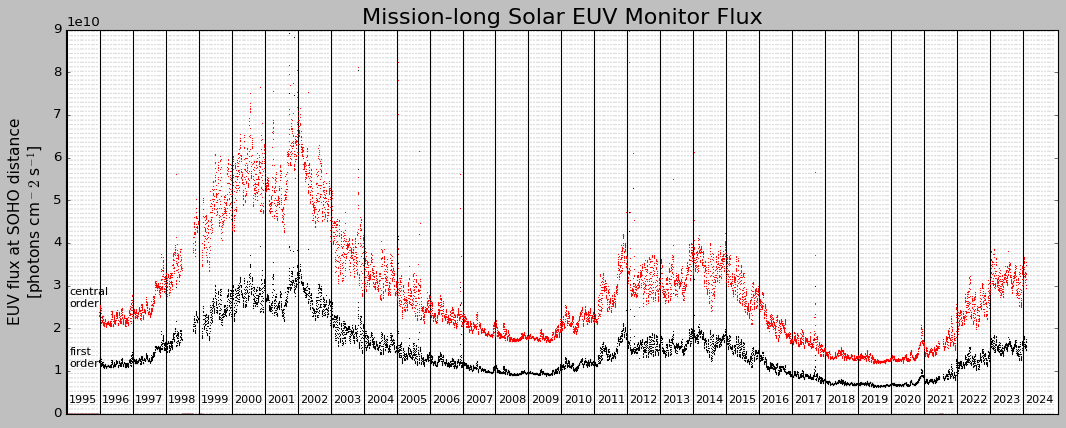

In [4]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(dates, firstOrderFluxes, 'k.',ms=1)
ax.plot(dates, centralOrderFluxes, 'r.',ms=1)

ax.set_xlim(dates[0] - 10, dates[-1] + 350)
ax.set_xticks([])
for y in range(1995, 2025):
    jan1 = str(y) + '-01-01T00:00:00.000Z'
    jan1 = astropy.time.Time(jan1).jd
    ax.axvline(jan1, color='k', ls='-', lw=1, zorder=1)
    
    ax.text(jan1+25, 0.025e11, str(y), zorder=4,fontsize=10)
        
    for m in range(2,13):
        m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
        m1 = astropy.time.Time(m1).jd
        ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)

ax.set_ylim(0.,0.9e11)
ax.text(dates[0]+25,1.1e10,'first'+'\n'+'order',fontsize=10)
ax.text(dates[0]+25,2.5e10,'central'+'\n'+'order',fontsize=10)

ax.set_ylabel(r'EUV flux at SOHO distance'+'\n'+'[photons cm${^-2}$ s$^{-1}$]',fontsize=14)
ax.set_title('Mission-long Solar EUV Monitor Flux',fontsize=20)

#plt.show()
plt.savefig("./SEM_missionlong.pdf",bbox_inches="tight")

In [5]:
# Compare SEM LC to VIRGO TSI LC
# Start 16 April 1996, the date at which SoHO was "fully commissioned for operations" per science.nasa.gov/mission/soho

TSIdaily = Table.read("./VIRGO/VIRGO_TSI_daily.dat", format="ascii.basic")
TSIdaily['jd'] = 0.

for i in range(len(TSIdaily)):
    date = str(TSIdaily['date_YYYYMMDD'][i])
    y = int(date[0:4])
    m = int(date[4:6])
    d = int(date[6:8])
    TSIdaily[i]['jd'] = astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':12}).jd

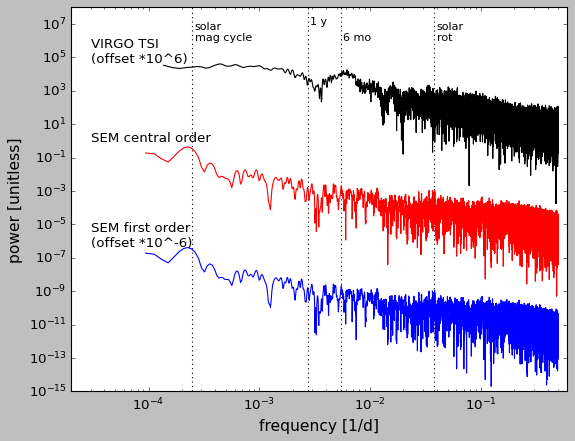

In [24]:
#cadence = 1 day
firstOrder_frequency, firstOrder_power = LombScargle(dates,firstOrderFluxes).autopower(minimum_frequency=(1./np.ptp(dates)), maximum_frequency=(1./2.))
centralOrder_frequency, centralOrder_power = LombScargle(dates,centralOrderFluxes).autopower(minimum_frequency=(1./np.ptp(dates)), maximum_frequency=(1./2.))

TSI_frequency, TSI_power = LombScargle(TSIdaily['jd'],TSIdaily['VIRGO_new']).autopower(minimum_frequency=(1./np.ptp(TSIdaily['jd'])), maximum_frequency=(1./2.))

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.axvline(1./26.24,color='k',ls=':')     #solar rotation
ax.axvline(1./365.,color='k',ls=':')      #1 year
ax.axvline(1./(11*365.),color='k',ls=':') #magnetic cycle
ax.axvline(1./(365./2), color='k',ls=':')

ax.text(1.05/26.24, 1.e6, 'solar'+'\n'+'rot',fontsize=10)
ax.text(1.05/(365/2), 1.e6, '6 mo',fontsize=10)
ax.text(1.05/365., 1.e7, '1 y',fontsize=10)
ax.text(1.05/(365*11), 1.e6, 'solar'+'\n'+'mag cycle',fontsize=10)

ax.plot(firstOrder_frequency, firstOrder_power*1.e-6, 'b-')
ax.plot(centralOrder_frequency, centralOrder_power, 'r-')
ax.plot(TSI_frequency, TSI_power*1.e6, 'k-')
ax.text(3.e-5, 5.e4, "VIRGO TSI"+"\n"+"(offset *10^6)", fontsize=12)
ax.text(3.e-5, 1.e0, "SEM central order", fontsize=12)
ax.text(3.e-5, 5.e-7, "SEM first order"+"\n"+"(offset *10^-6)", fontsize=12)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_xlim(2.e-5, 6.e-1)
ax.set_ylim(1.e-15, 1.e8)
#plt.show()
plt.savefig("VIRGO_SEM_LSperiodogram.pdf",bbox_inches="tight")
    

In [25]:
print(TSIdaily)
print

date_YYYYMMDD VIRGO_new  VIRGO_orig DIARAD_orig PMO6V_orig     jd   
------------- ---------- ---------- ----------- ---------- ---------
     19960128 1360.71285 1365.65491       -99.0 1365.31482 2450111.0
     19960129 1360.70884 1365.65088       -99.0 1365.31116 2450112.0
     19960130 1360.72076 1365.66284       -99.0 1365.32349 2450113.0
     19960131 1360.73134 1365.67346       -99.0 1365.33411 2450114.0
     19960201 1360.74691 1365.68909       -99.0 1365.34998 2450115.0
     19960202 1360.74217 1365.68433       -99.0 1365.34521 2450116.0
     19960203 1360.69887 1365.64087       -99.0   1365.302 2450117.0
     19960204 1360.65508 1365.59692       -99.0 1365.25818 2450118.0
     19960205  1360.6355 1365.57727       -99.0 1365.23865 2450119.0
     19960206 1360.64511 1365.58691       -99.0 1365.24866 2450120.0
     19960207   1360.658 1365.59985  1365.95032 1365.25623 2450121.0
     19960208 1360.62783 1365.56958  1365.90845 1365.23157 2450122.0
     19960209 1360.63635 1365.5781

<function print>

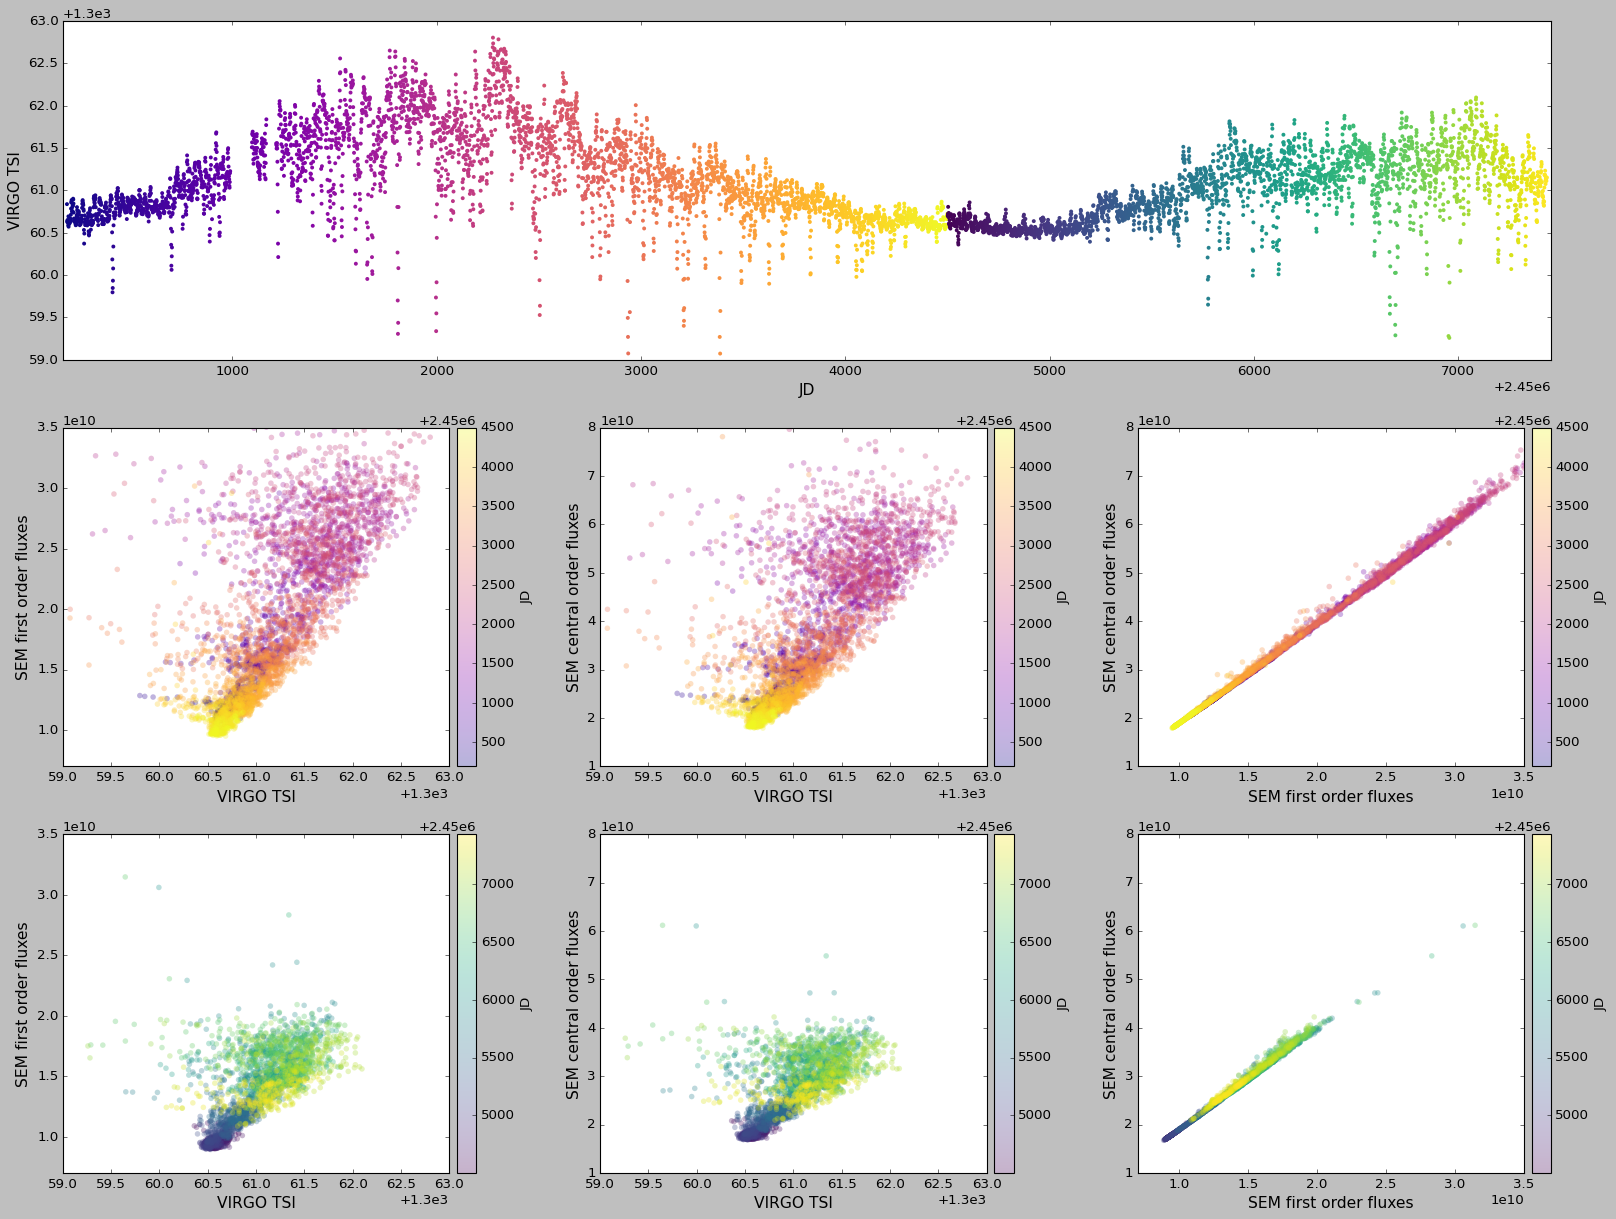

In [28]:
#consider same date range---post SoHO fully commissioned, pre end of VIRGO TSI obs
TSIdatemask = (TSIdaily['jd'] > april16_1996)
SEMdatemask = (dates > 2450189.5) & (dates <= TSIdaily['jd'][-1])

TSIdatemask23 = (TSIdaily['jd'] > april16_1996) & (TSIdaily['jd'] <= 2454500.)
SEMdatemask23 = (dates > 2450189.5) & (dates <= 2454500.)

TSIdatemask24 = (TSIdaily['jd'] > 2454500.) 
SEMdatemask24 = (dates > 2454500.) & (dates <= TSIdaily['jd'][-1])


qualityMask23 = (TSIdaily['VIRGO_new'][TSIdatemask23] > 0.)
#print(len(TSIdaily[TSIdatemask]))
#print(len(dates[SEMdatemask]))
#print(len(TSIdaily[TSIdatemask23]))
#print(len(dates[SEMdatemask23]))
#print(len(TSIdaily[TSIdatemask24]))
#print(len(dates[SEMdatemask24]))

fig = plt.figure(figsize=(24,18))
gs = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
LCax = fig.add_subplot(gs[0,:])

ax0 = fig.add_subplot(gs[1, 0])  
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax3 = fig.add_subplot(gs[2, 0])  
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[2, 2])
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

LCax.scatter(TSIdaily['jd'][TSIdatemask23], TSIdaily['VIRGO_new'][TSIdatemask23], c=TSIdaily['jd'][TSIdatemask23], cmap='plasma', marker='.', s=50, edgecolor='None')
LCax.scatter(TSIdaily['jd'][TSIdatemask24], TSIdaily['VIRGO_new'][TSIdatemask24], c=TSIdaily['jd'][TSIdatemask24], cmap='viridis', marker='.', s=50, edgecolor='None')

#axes[0].plot(TSIdaily['VIRGO_new'][TSIdatemask23][qualityMask23], firstOrderFluxes[SEMdatemask23][qualityMask23], 'k-',marker='None',zorder=1,lw=0.5)
cs0 = axes[0].scatter(TSIdaily['VIRGO_new'][TSIdatemask23], firstOrderFluxes[SEMdatemask23], c=dates[SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[0].set_xlabel("VIRGO TSI",fontsize=14)
axes[0].set_ylabel("SEM first order fluxes",fontsize=14)

#axes[1].plot(TSIdaily['VIRGO_new'][TSIdatemask23], centralOrderFluxes[SEMdatemask23], 'k-',marker='None',zorder=1,lw=0.5)
cs1 = axes[1].scatter(TSIdaily['VIRGO_new'][TSIdatemask23], centralOrderFluxes[SEMdatemask23], c=dates[SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[1].set_xlabel("VIRGO TSI",fontsize=14)
axes[1].set_ylabel("SEM central order fluxes",fontsize=14)

cs2 = axes[2].scatter(firstOrderFluxes[SEMdatemask23], centralOrderFluxes[SEMdatemask23],  c=dates[SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[2].set_xlabel("SEM first order fluxes",fontsize=14)
axes[2].set_ylabel("SEM central order fluxes",fontsize=14)

#axes[3].plot(TSIdaily['VIRGO_new'][TSIdatemask24], firstOrderFluxes[SEMdatemask24], 'k-',marker='None',zorder=1,lw=0.5)
cs3 = axes[3].scatter(TSIdaily['VIRGO_new'][TSIdatemask24], firstOrderFluxes[SEMdatemask24], c=dates[SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[3].set_xlabel("VIRGO TSI",fontsize=14)
axes[3].set_ylabel("SEM first order fluxes",fontsize=14)

#axes[4].plot(TSIdaily['VIRGO_new'][TSIdatemask24], centralOrderFluxes[SEMdatemask24], 'k-',marker='None',zorder=1,lw=0.5)
cs4 = axes[4].scatter(TSIdaily['VIRGO_new'][TSIdatemask24], centralOrderFluxes[SEMdatemask24], c=dates[SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[4].set_xlabel("VIRGO TSI",fontsize=14)
axes[4].set_ylabel("SEM central order fluxes",fontsize=14)

cs5 = axes[5].scatter(firstOrderFluxes[SEMdatemask24], centralOrderFluxes[SEMdatemask24],  c=dates[SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[5].set_xlabel("SEM first order fluxes",fontsize=14)
axes[5].set_ylabel("SEM central order fluxes",fontsize=14)

cs = [cs0, cs1, cs2, cs3, cs4, cs5]
for i, ax in enumerate(axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(cs[i], cax=cax,label="JD")

LCax.set_xlim(TSIdaily['jd'][TSIdatemask][0] - 20, TSIdaily['jd'][TSIdatemask][-1] + 20)
LCax.set_ylim(1359, 1363)
LCax.set_xlabel('JD',fontsize=14)
LCax.set_ylabel('VIRGO TSI',fontsize=14)

for ax in [ax0, ax3]:
    ax.set_xlim(1359,1363)
    ax.set_ylim(0.7e10,3.5e10)

for ax in [ax1, ax4]:
    ax.set_xlim(1359,1363)
    ax.set_ylim(0.1e11,0.8e11)

for ax in [ax2, ax5]:
    ax.set_xlim(0.7e10,3.5e10)
    ax.set_ylim(0.1e11,0.8e11)

plt.subplots_adjust(wspace = 0.3)
#plt.show()
plt.savefig("VIRGO_SEM_fluxcorr.pdf",bbox_inches="tight")